In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
print(DOW_30_TICKER)


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)


In [5]:
len(df.tic.unique())

30

In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
train_data = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)

In [11]:
display(train_data.tail(5))

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
2956,2021-09-30,401.489990,403.489990,390.459991,375.759796,3779900,UNH,3,-4.265032,411.094087,379.372042,40.895423,-222.754127,41.980385,398.086168,397.586977,24.871975
2956,2021-09-30,227.580002,228.789993,222.630005,218.139236,7128500,V,3,-1.523927,226.440136,214.446924,44.078993,-54.509509,19.569853,222.615294,229.252969,24.871975
2956,2021-09-30,54.500000,54.509998,54.000000,45.622715,18736600,VZ,3,-0.217510,46.664910,45.373697,41.824959,-102.367268,21.682953,46.175152,46.664380,24.871975
2956,2021-09-30,48.790001,48.930000,46.919998,40.519119,6449400,WBA,3,-0.233708,44.735833,40.187239,44.613725,-106.638134,0.941150,42.297479,41.349181,24.871975
2956,2021-09-30,46.880001,47.243332,46.416668,44.566536,22457700,WMT,3,-0.509082,47.853936,44.408838,40.165829,-151.493731,45.479205,46.606534,46.246836,24.871975


In [45]:
print(len(train_data))
print(len(trade_data))

85753
10266


In [46]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [68]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "num_stock_shares": [0] * stock_dimension,
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [69]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [70]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 107       |
|    iterations      | 1         |
|    time_elapsed    | 19        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.7125272 |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 284         |
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2           |
|    time_elapsed         | 38          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013667695 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0115     |
|    learning_rate        | 0.00025     |
|    loss    

In [72]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_train_gym)

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4357829.46
total_reward: 3357829.46
total_cost: 2436.54
total_trades: 33664
Sharpe: 0.894
hit end!


In [73]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

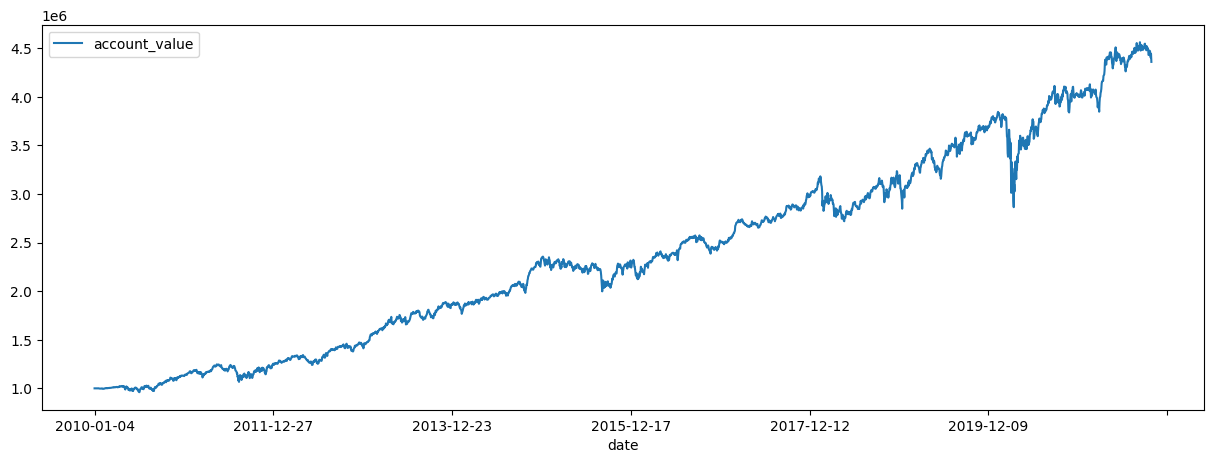

In [74]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
df_result_ppo.plot()

In [92]:
df_dji = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = ['dji']).fetch_data()
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2789, 8)


In [93]:
result = pd.DataFrame()
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

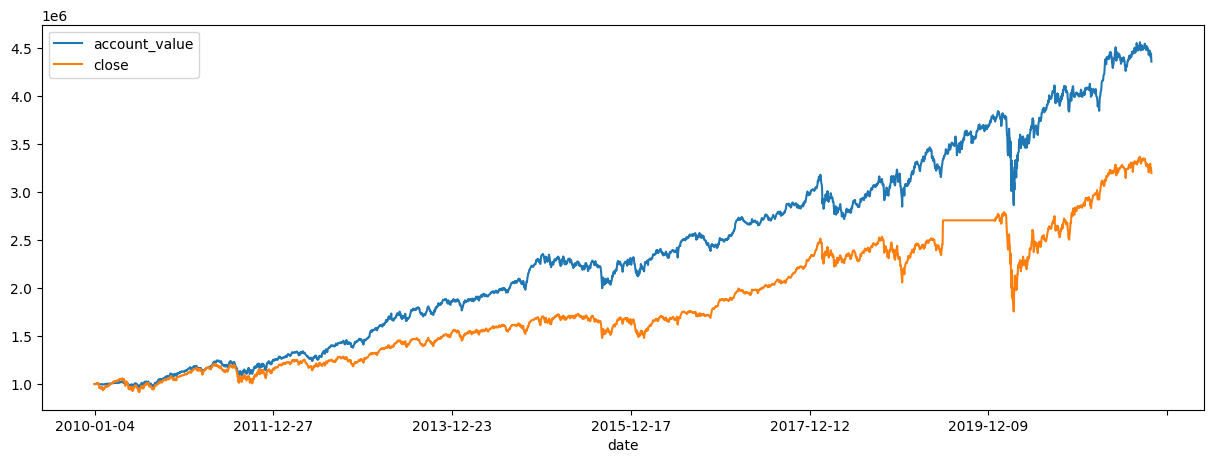

In [94]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()